In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [318]:
from telesketch.envs.continous_telesketch import ContiousTelesketch

import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.metrics import normalized_root_mse
from gymnasium import spaces
from math import pi

In [319]:
rmse = lambda x, y: np.sum((x - y) ** 2)
nrmse = lambda x, y: normalized_root_mse(x, y)

# Ref canvas
ref_canvas = np.full((64, 64, 3), 255, dtype=np.uint8)
ref_canvas = cv2.line(ref_canvas, (0, 0), (32, 32), (0, 0, 0), 2)
ref_canvas = cv2.line(ref_canvas, (32, 32), (64, 32), (0, 0, 0), 2)

env = ContiousTelesketch(
    ref_canvas,
    rmse,
    lambda x, y: rmse(x, y) < 0.10,
    lambda diff: diff if diff > 0 else diff * 0.5,
    (5, 15),
    2
)

In [330]:
x = env.reset()

192.0
-15.0


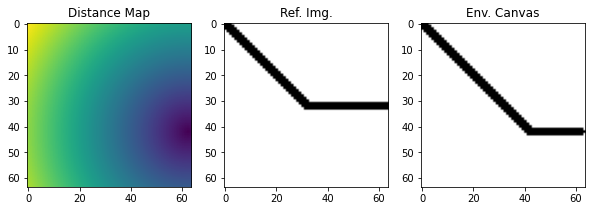

In [338]:

print(env.step(-2*pi, 10)[1])
env.render(figsize=(10, 10))